**NOT WORKING PROPERLY**

- [ ] Check the expression for derivatives and break it down

# Graph Constructor for Differential Equations

To solve the differential equation, we require a graph that represents the structure of differential equation.

Suppose we are solving the equation
$$
\frac{dy(t)}{dt} = y.
$$
The graph for $y(t)$  can be constructed easily in PyTorch. However, we need to find a way to construct the complete network that represents the differential equation, thus we need another graph that represents $dy/dt$.

In general, we approximate the function $y(t)$ as
$$
y(x_i) = y(x_{init}) + x_i \sum_k v_k R(t_i w_k + u_k)
$$
which leads to the approximation of $dy/dt$

The derivative can be approximated using
$$
\frac{dy}{dx}(x_i) = \sum_k v_k R(t_i w_k + u_k) + x_i \sum_k v_k R'(t_i w_k + u_k) w_k
$$

In [1]:
# Import modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('seaborn-poster')

In [60]:
# Construct the network for y

dtype=torch.Tensor

## Number of input
N = 100
## number of neurons
H = 100

learning_rate = 1e-6

data_x = np.linspace(0,1,N)
data_ones = np.ones(N)
data_ones_h = np.ones(H)
data_train = np.zeros(N)

ta_x = Variable( torch.from_numpy( data_x ).type(dtype), requires_grad=False )
ta_ones = Variable( torch.from_numpy( data_ones ).type(dtype), requires_grad=False )
ta_data_train = Variable( torch.from_numpy(data_train).type(dtype), requires_grad=False )

ta_v = Variable(torch.randn(H).type(dtype), requires_grad = True)
ta_w = Variable(torch.randn(H).type(dtype), requires_grad = True)
ta_u = Variable(torch.randn(H).type(dtype), requires_grad = True)
ta_ones_h =  Variable( torch.from_numpy( data_ones_h ).type(dtype), requires_grad=False )



In [61]:
act = nn.Sigmoid()

In [62]:
ta_trial_data = []

for t in range(100000):
    
#     ta_y_pred = ta_x.mm( ta_w1 ).clamp( min=0 ).mm(ta_w2)
#     print( torch.matmul( ta_v,act(torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ) ) )
    ta_data_pred = 1 + ta_x * ( torch.matmul( ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) ) ) )
    ta_data_derivative = ( torch.matmul( ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) ) ) ) + ta_x *  ( torch.matmul( ta_w*ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) * ( 1 - act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  )  )  )      ) )
    
    ta_loss = (ta_data_derivative + ta_data_pred ).pow(2).sum()
    
    ta_loss.backward()
    
    ta_v.data -= learning_rate* ta_v.grad.data
    ta_w.data -= learning_rate* ta_w.grad.data
    ta_u.data -= learning_rate* ta_u.grad.data
    
    ta_v.grad.data.zero_()
    ta_w.grad.data.zero_()
    ta_u.grad.data.zero_()
    
    ta_trial_data.append( [t, ta_loss.data[0]] )

#     print(t, ta_loss.data[0])



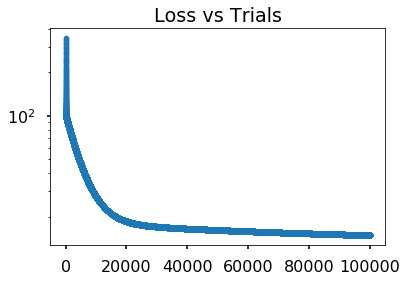

In [63]:
ta_trial_data_plt = np.transpose(ta_trial_data)
plt.semilogy( ta_trial_data_plt[0], ta_trial_data_plt[1], '.' )
plt.title('Loss vs Trials')
plt.show()

# Reconstruct the Function

In [64]:
test_data = 1 + ta_x * ( torch.matmul( ta_v, ( act( (torch.ger( ta_x, ta_w ) + torch.ger( ta_ones, ta_u ) ).float()  ) ) ) )

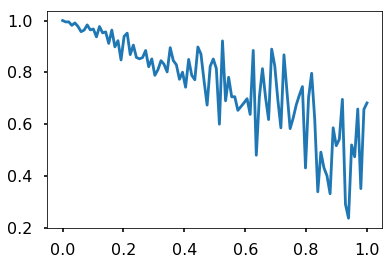

In [65]:
plt.plot(data_x, test_data.data.numpy() )

# Test

In [11]:
test_a = Variable( torch.from_numpy( np.arange(10) ), requires_grad = False )
test_b = Variable( torch.from_numpy( np.arange(10,20) ), requires_grad = False )
test_c = Variable( torch.from_numpy( np.arange(20,50).reshape(3,10) ), requires_grad = False )


In [18]:
torch.ger(test_a, test_b)

Variable containing:
    0     0     0     0     0     0     0     0     0     0
   10    11    12    13    14    15    16    17    18    19
   20    22    24    26    28    30    32    34    36    38
   30    33    36    39    42    45    48    51    54    57
   40    44    48    52    56    60    64    68    72    76
   50    55    60    65    70    75    80    85    90    95
   60    66    72    78    84    90    96   102   108   114
   70    77    84    91    98   105   112   119   126   133
   80    88    96   104   112   120   128   136   144   152
   90    99   108   117   126   135   144   153   162   171
[torch.LongTensor of size 10x10]

In [9]:
test_a * test_b

Variable containing:
   0
  11
  24
  39
  56
  75
  96
 119
 144
 171
[torch.LongTensor of size 10]

In [26]:
act(test_c.float()/100)

Variable containing:
 0.5498  0.5523  0.5548  0.5572  0.5597  0.5622  0.5646  0.5671  0.5695  0.5720
 0.5744  0.5769  0.5793  0.5818  0.5842  0.5866  0.5890  0.5915  0.5939  0.5963
 0.5987  0.6011  0.6035  0.6059  0.6083  0.6106  0.6130  0.6154  0.6177  0.6201
[torch.FloatTensor of size 3x10]

In [27]:
1-test_c

Variable containing:
  -19   -20   -21   -22   -23   -24   -25   -26   -27   -28
  -29   -30   -31   -32   -33   -34   -35   -36   -37   -38
  -39   -40   -41   -42   -43   -44   -45   -46   -47   -48
[torch.LongTensor of size 3x10]